#  Replicating Hochberg book
## Charge simulation

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
from generate_mesh import gen_mesh

import devsim as ds

In [2]:
# all units in um
w_core = 0.25
h_core = 0.22
#w_clearance = 0.5
w_clearance = 2.25
h_clearance = 0.09
w_side = 2.5
h_side = 0.22

w_contact = 1.2
h_contact = 0.2

z_size = h_clearance/5

res = h_clearance/10

#z_size = h_clearance/2

# modulator doping concentrations (1/cm^3)
conc_p = 7e17 + 1e15
conc_n = 5e17

conc_contact = 5e18

### Generate 2D doping

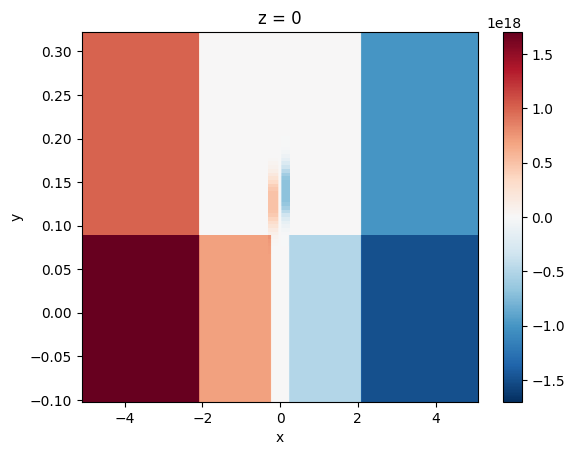

In [3]:
# get 2D doping distributions and visualize
import doping_hochberg as doping
acceptors_dist, donors_dist = doping.get_dopings_hochberg()
(acceptors_dist-donors_dist).plot(y="y")

### Create mediums

In [4]:
SiO2 = td.Medium(
    electric_spec=td.InsulatorSpec(permittivity=3.9), name="SiO2",
)

Si_2D_doping = td.Medium(
    electric_spec=td.SemiConductorSpec(
        conductivity=1,
        permittivity=11.7,
        donors=0,
        acceptors=acceptors_dist-donors_dist,
    ),
    name="Si_nnn",
)

aux_left = td.Medium(
    heat_spec=td.FluidSpec(),
    name="aux_left"
)

aux_right = td.Medium(
    heat_spec=td.FluidSpec(),
    name="aux_right"
)

air = td.Medium(heat_spec=td.FluidSpec(), name="air")

### Generate structures

In [5]:
# create objects
overlap_factor = 1.0001

oxide = td.Structure(
    geometry=td.Box(center=(0, h_core, 0), size=(7, 8, z_size)),
    medium=SiO2,
    name="oxide"
)

core_p = td.Structure(
    geometry=td.Box(center=(-w_core/2, h_core/2, 0), size=(w_core, h_core, z_size)),
    medium=Si_2D_doping,
    name="core_p"
)

core_n = td.Structure(
    geometry=td.Box(center=(w_core/2, h_core/2, 0), size=(w_core, h_core, z_size)),
    medium=Si_2D_doping,
    name="core_n"
)

clearance_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, z_size)),
    medium=Si_2D_doping,
    name="clearance_p"
)

clearance_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, z_size)),
    medium=Si_2D_doping,
    name="clearance_n"
)

side_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side/2, h_side/2, 0), size=(w_side, h_side, z_size)),
    medium=Si_2D_doping,
    name="side_p"
)

side_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side/2, h_side/2, 0), size=(w_side, h_side, z_size)),
    medium=Si_2D_doping,
    name="side_n"
)

# create a couple structs to define the contacts
contact_left = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side + w_contact/2, h_side + h_contact/2, 0), size=(w_contact, h_contact, z_size)),
    medium=aux_left,
    name="contact_left"
)

contact_right = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side - w_contact/2, h_side + h_contact/2, 0), size=(w_contact, h_contact, z_size)),
    medium=aux_right,
    name="contact_right"
)

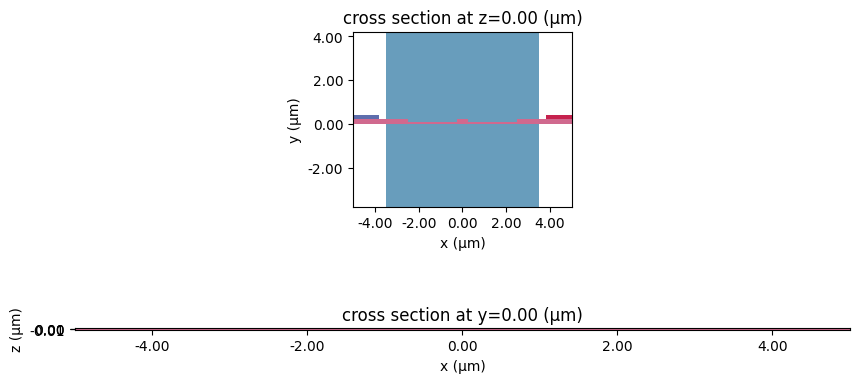

In [6]:
# create a scene with the previous structures
all_structures = [oxide, core_p, core_n, clearance_n, clearance_p, side_p, side_n, contact_left, contact_right]

scene = td.Scene(
    medium=air,
    structures=all_structures,
)


_, ax = plt.subplots(2, 1, figsize=(10, 5))

scene.plot(z=0, ax=ax[0])
scene.plot(y=5e-6, ax=ax[1])
plt.show()

### BCs

In [7]:
# create BCs
voltages = list(np.linspace(-0.5, 4, 20))
voltages = [-0.5, 0, 0.5, 1.5, 2, 2.5, 3, 3.5, 4]
#voltages = [0, 0.1, 0.2]
bc_v1 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(voltage=0),
    placement=td.MediumMediumInterface(mediums=[aux_left.name, Si_2D_doping.name]),
)

bc_v2 = td.HeatChargeBoundarySpec(
    #condition=td.VoltageBC(voltage=0),
    condition=td.VoltageBC(voltage=voltages),
    placement=td.MediumMediumInterface(mediums=[aux_right.name, Si_2D_doping.name]),
)

boundary_conditions = [bc_v1, bc_v2]

### Monitors

In [8]:
# global monitor (Will be used later for the mode simulations)
charge_global_mnt = td.ChargeSimulationMonitor(
    center=(0, 0.14, 0), size=(td.inf, td.inf, td.inf), name="charge_global_mnt", unstructured=True
)

# monitors around the waveguide
charge_3D_mnt = td.ChargeSimulationMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, td.inf), name="charge_3D_mnt", unstructured=True
)

charge_monitor_z0 = td.ChargeSimulationMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, 0), name="charge_z0", unstructured=True, 
)

### Create simulation

In [9]:
# devsim setting 
from tidy3d import DevsimConvergenceSettings
convergence_settings = DevsimConvergenceSettings(relTol=1e5, absTol=1e3, maxIters=400, dV=1)
#convergence_settings = DevsimConvergenceSettings(relTol=1e15, absTol=1e8, maxIters=400, dV=0.3)

<Axes: title={'center': 'cross section at z=0.00 (μm)'}, xlabel='x (μm)', ylabel='y (μm)'>

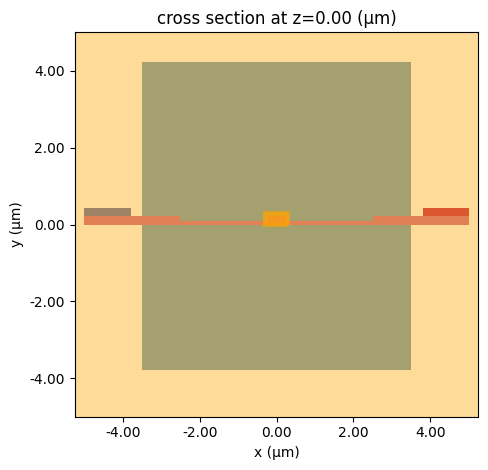

In [10]:
# mesh
mesh = td.UniformUnstructuredGrid(dl=res, relative_min_dl=0)
mesh = td.DistanceUnstructuredGrid(dl_interface=res*0.75, dl_bulk=res*1.95, distance_interface=0.5*h_side,
                                  distance_bulk=2*h_side, relative_min_dl=0,
                                   non_refined_structures=[oxide.name, clearance_n.name, clearance_p.name, side_p.name, side_n.name]
                                  )
mesh = td.DistanceUnstructuredGrid(dl_interface=res*0.75, dl_bulk=res*4, distance_interface=0.5*h_side,
                                  distance_bulk=1*h_side, relative_min_dl=0,
                                   non_refined_structures=[oxide.name, clearance_n.name, clearance_p.name, side_p.name, side_n.name]
                                  )

# build heat simulation object
heat_sim = td.HeatChargeSimulation(
    sources=[],
    monitors=[charge_global_mnt, charge_3D_mnt, charge_monitor_z0],
    devsim_settings=[convergence_settings],
    center=(0,0,0),
    size=(10.5,10,5),
    structures=all_structures,
    medium=air,
    boundary_spec=boundary_conditions,
    grid_spec=mesh,
    #grid_spec=td.UniformUnstructuredGrid(dl=res, relative_min_dl=3e-7),
    symmetry=(0, 0, 0)
    )
heat_sim.plot(z=0)

### Run pipeline

In [11]:
%matplotlib inline
#heat_sim_data = gen_mesh(heat_sim)
from run_drift import run_drift
devsim_data = run_drift(heat_sim)

[24-10-24 12:26:41.862][DEBUG  ]: Remote run: False
[24-10-24 12:26:41.862][DEBUG  ]: Listing client arguments: 
[24-10-24 12:26:41.862][DEBUG  ]:    checkEstimateUri: 
[24-10-24 12:26:41.862][DEBUG  ]:    estWorkUnitFile: ./tmp/est_work_unit.json
[24-10-24 12:26:41.862][DEBUG  ]:    ignoreError: false
[24-10-24 12:26:41.862][DEBUG  ]:    validateOnly: false
[24-10-24 12:26:41.862][DEBUG  ]:    resourceId: tmp
[24-10-24 12:26:41.862][DEBUG  ]:    releasePath: /home/marc/Documents/src/tidy3d-core/_build_release
[24-10-24 12:26:41.862][DEBUG  ]:    fileSystem: distributed
[24-10-24 12:26:41.862][SUPPORT]: Starting tidy3dHeatMetaDataPipeline for task id tmp
[24-10-24 12:26:41.862][SUPPORT]: Using 'simulation.hdf5' file found in folder.
[24-10-24 12:26:41.862][DEBUG  ]: Starting heavy imports
[24-10-24 12:26:41.863][DEBUG  ]: Done with heavy imports
[24-10-24 12:26:41.953][DEBUG  ]: Listing metadata client updates                                                       
[24-10-24 12:26:41.95

Traceback (most recent call last):
  File "/home/marc/Documents/src/tidy3d-core/_build_release/bin/denormalize.py", line 32, in <module>
    denormalize(simfile, save_dir)
  File "/home/marc/Documents/tidy3D_python/tidy3d_local/lib/python3.12/site-packages/tidy3d_denormalizer/denormalizer.py", line 207, in denormalize
    denormalize_directly(sim_data=sim_data, base_dir=base_dir)
                                  ^^^^^^^^
UnboundLocalError: cannot access local variable 'sim_data' where it is not associated with a value
Traceback (most recent call last):
  File "/home/marc/Documents/src/tidy3d-core/_build_release/bin/flow360runner.py", line 36, in <module>
    subprocess.check_call([sys.executable, '-u'] + args)
  File "/usr/lib/python3.12/subprocess.py", line 413, in check_call
    raise CalledProcessError(retcode, cmd)
subprocess.CalledProcessError: Command '['/home/marc/Documents/tidy3D_python/tidy3d_local/bin/python3', '-u', '/home/marc/Documents/src/tidy3d-core/_build_release/bin/d

[24-10-24 12:35:25.940][SUPPORT]: **********   End content of postVizDenormalize.log **********
[24-10-24 12:35:25.940][SUPPORT]: Finishing postVizDenormalize: execution time is 1.31 seconds
[24-10-24 12:35:25.940][DEBUG  ]: runCommand for postVizDenormalize failed
[24-10-24 12:35:25.940][SUPPORT]: runCommand for postVizDenormalize failed
[24-10-24 12:35:25.940][SUPPORT]: Running UpdateClient2 : /bin/true denormalizeStatus : error
[24-10-24 12:35:25.941][SUPPORT]: **********   Begin content of UpdateClient2.log **********
[24-10-24 12:35:25.941][SUPPORT]: **********   End content of UpdateClient2.log **********
[24-10-24 12:35:25.941][SUPPORT]: Finishing UpdateClient2: execution time is 0.00 seconds
[24-10-24 12:35:25.942][SUPPORT]: Processing Tidy3D Heat Solver, pipeline tidy3dHeatSolverPipeline complete.


12:35:26 CEST WARNING: Could not execute validator 'warn_no_data' because field 
              'monitor' failed validation.                                      

12:35:27 CEST WARNING: Could not execute validator 'warn_no_data' because field 
              'monitor' failed validation.                                      

              WARNING: Could not execute validator 'warn_no_data' because field 
              'monitor' failed validation.                                      

### Post-process Charge simmulation

(-0.5, 0.0, 0.5, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0)


/home/marc/Documents/tidy3D_python/tidy3d_local/lib/python3.12/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


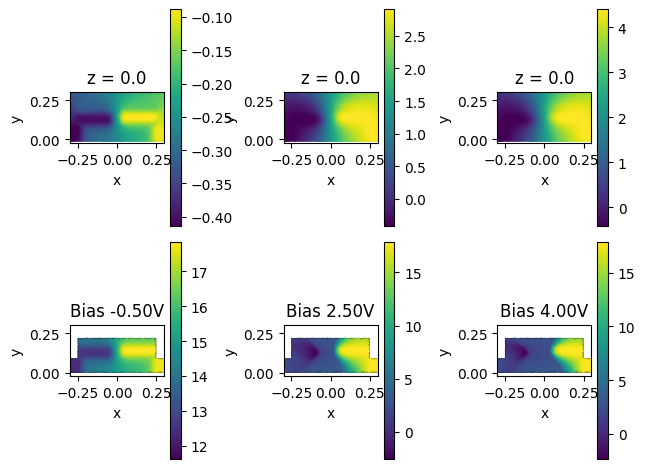

In [12]:
#devsim_data[volt_y0_mnt.name].voltage.sel(z=0).plot(grid=False)
print(devsim_data[charge_monitor_z0.name].data_series.parameter_array)

indices = [0]
indices.append(int(np.ceil(devsim_data[charge_monitor_z0.name].data_series.num_fields_saved/2)))
indices.append(int(np.ceil(devsim_data[charge_monitor_z0.name].data_series.num_fields_saved-1)))

series = devsim_data[charge_monitor_z0.name].data_series
sets_to_plot = [[], []]
if devsim_data[charge_monitor_z0.name].data_series.num_fields_saved > 2:
    fig, ax = plt.subplots(2, 3)
    for n, index in enumerate(indices):
        sets_to_plot[0].append(
            devsim_data[charge_monitor_z0.name].data_series.get_field("Potential", index)
        )
        sets_to_plot[0][n].plot(ax=ax[0][n], grid=False)
        ax[0][n].set_xlim((-0.3, 0.3))
        sets_to_plot[1].append(
            np.log10(devsim_data[charge_monitor_z0.name].data_series.get_field("Electrons", index))
        )
        sets_to_plot[1][n].plot(ax=ax[1][n], grid=False)
        ax[1][n].set_title("Bias {0:0.2f}V".format(series.parameter_array[index]))
        ax[1][n].set_xlim((-0.3, 0.3))

plt.tight_layout()

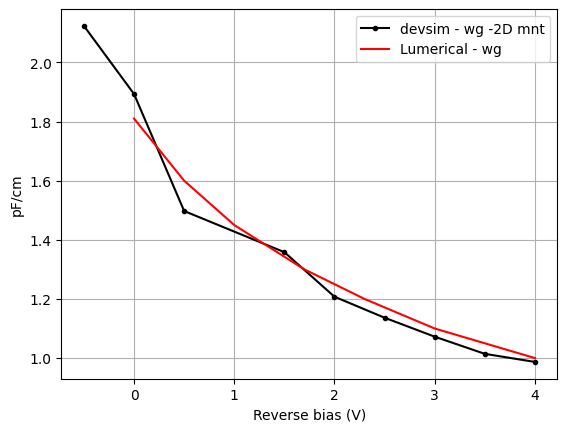

In [13]:
# capacitance from monitor - waveguide area

c_lumerical_wg_in_air = np.array([0.095, 0.155, 0.14, 0.12, 0.11, 0.1, 0.0925, 0.084])
b_lumerical_wg_in_air = np.array([-0.4, 0,     0.4,  1.1,  1.65, 2.3, 3,     4])

c_lumerical_wg_in_SiO2 = np.array([0.181, 0.16, 0.145, 0.13, 0.12, 0.11, 0.1])
b_lumerical_wg_in_SiO2 = np.array([0,     0.5,   1,    1.7,  2.3,  3,     4])

c_lumerical_wg_deg_in_Air = np.array([0.19, 0.1551, 0.1357, 0.12, 0.11, 0.1, 0.09, 0.085])
b_lumerical_wg_deg_in_Air = np.array([-0.4, 0,     0.5,     1.15,  1.7,  2.4, 3.3,  4])

mnt_v = np.array(devsim_data[charge_monitor_z0.name].capacitance_curve["cv_curve_e"].coords["Voltage (V)"].data)
mnt_ce = np.array(devsim_data[charge_monitor_z0.name].capacitance_curve["cv_curve_e"].data)
mnt_ch = np.array(devsim_data[charge_monitor_z0.name].capacitance_curve["cv_curve_h"].data)

plt.plot(mnt_v, -0.5*(mnt_ce+mnt_ch) * 10, 'k.-', label="devsim - wg -2D mnt")
#plt.plot(mnt_v, -0.5*(mnt_3D_ce+mnt_3D_ch) * 10/ z_size, 'b.-', label="devsim - wg -3D mnt")
#plt.plot(b_lumerical_wg_in_air, c_lumerical_wg_in_air*10, 'r-', label="Lumerical - wg")
plt.plot(b_lumerical_wg_in_SiO2, c_lumerical_wg_in_SiO2*10, 'r-', label="Lumerical - wg")
#plt.plot(b_lumerical_wg_deg_in_Air, c_lumerical_wg_deg_in_Air*10, 'r-', label="Lumerical - wg")
plt.xlabel("Reverse bias (V)")
plt.ylabel("pF/cm")
plt.legend()
plt.grid()
#devsim_data[charge_monitor_z0.name].capacitance_curve["cv_curve_e"].plot()

## Generate Charge-dependent perturbation material

In [14]:
# define first the range of frequencies of interest

wvl_um = 1.55
freq0 = td.C_0 / wvl_um

fwidth = freq0 / 5
freqs = np.linspace(freq0 - fwidth / 10, freq0 + fwidth / 10, 201)
wvls = td.C_0 / freqs

# max/min wavelengths
print(np.max(wvls), np.min(wvls))

1.5816326530612244 1.519607843137255


In [15]:
si = td.material_library['cSi']['Palik_Lossless']
SiO2_lib = td.material_library['SiO2']['Palik_Lossy']

n_si, k_si = si.nk_model(frequency=td.C_0 / wvl_um)

In [16]:
# Import material data from Lumerical (see notebook "Lumerical_material_fitting.ipynt")
#Si_lumerical = td.PoleResidue.from_file("fitted_si.json")
#SiO2_lumerical = td.PoleResidue.from_file("fitted_sio2.json")

# using fitted Lumerical material properties
#n_si, k_si = Si_lumerical.nk_model(frequency=td.C_0 / wvl_um)

#print(si.eps_comp(row=0, col=0, frequency=td.C_0 / 1.55))
#print(Si_lumerical.eps_comp(row=0, col=0, frequency=td.C_0 / 1.55))

In [17]:
ne_coeff = -5.4e-22
ne_pow = 1.011

nh_coeff = -1.53e-18
nh_pow = 0.838

k_factor = wvl_um * 1e-4 / 4 / np.pi  # factor for conversion from absorption coefficient into k

ke_coeff = k_factor * 8.88e-21
ke_pow = 1.167

kh_coeff = k_factor * 5.84e-20
kh_pow = 1.109

In [18]:
Ne_range = np.concatenate(([0], np.logspace(-6, 20, num=200)))
Nh_range = np.concatenate(([0], np.logspace(-6, 20, num=200)))

Ne_mesh, Nh_mesh = np.meshgrid(Ne_range, Nh_range, indexing='ij')

dn_mesh = ne_coeff * Ne_mesh ** ne_pow + nh_coeff * Nh_mesh ** nh_pow
dk_mesh = ke_coeff * Ne_mesh ** ke_pow + kh_coeff * Nh_mesh ** kh_pow

In [19]:
si_non_perturb = td.Medium.from_nk(n=n_si, k=k_si, freq=freq0)

In [20]:
dn_data = td.ChargeDataArray(dn_mesh, coords=dict(n=Ne_range, p=Nh_range))
dk_data = td.ChargeDataArray(dk_mesh, coords=dict(n=Ne_range, p=Nh_range))

n_si_charge = td.CustomChargePerturbation(perturbation_values=dn_data)
k_si_charge = td.CustomChargePerturbation(perturbation_values=dk_data)

n_si_perturbation = td.ParameterPerturbation(
    charge=n_si_charge,
)

k_si_perturbation = td.ParameterPerturbation(
    charge=k_si_charge,
)

si_perturb = td.PerturbationMedium.from_unperturbed(
    medium=si_non_perturb,
    perturbation_spec=td.IndexPerturbation(
        delta_n=n_si_perturbation,
        delta_k=k_si_perturbation,
        freq=freq0,
    )
)

## Create mode simulation

### Regenerate structures with larger span and perturbed material

In [21]:
# create objects
span = 2*wvl_um
overlap_factor = 1.0001

oxide = td.Structure(
    geometry=td.Box(center=(0, h_core, 0), size=(7, 4, span)),
    medium=SiO2_lib,
    #medium=SiO2_lumerical,
    name="oxide"
)

core_p = td.Structure(
    geometry=td.Box(center=(-w_core/2, h_core/2, 0), size=(w_core, h_core, span)),
    medium=si_perturb,
    name="core_p"
)

core_n = td.Structure(
    geometry=td.Box(center=(w_core/2, h_core/2, 0), size=(w_core, h_core, span)),
    medium=si_perturb,
    name="core_n"
)

clearance_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, span)),
    medium=si_perturb,
    name="clearance_p"
)

clearance_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, span)),
    medium=si_perturb,
    name="clearance_n"
)

side_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side/2, h_side/2, 0), size=(w_side, h_side, span)),
    medium=si_perturb,
    name="side_p"
)

side_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side/2, h_side/2, 0), size=(w_side, h_side, span)),
    medium=si_perturb,
    name="side_n"
)

### Recreate scene

In [22]:
all_structures = [oxide, core_p, core_n, clearance_n, clearance_p, side_p, side_n]
all_structures = [core_p, core_n, clearance_n, clearance_p, side_p, side_n]

scene = td.Scene(
    medium=air,
    structures=all_structures,
)

### Define mode source

In [23]:
buffer = 1*wvl_um

port_center = (0,h_core,-span/2)
port_size = (5, 5, 0)

### Create simulation

In [24]:
sim_size = (10+buffer, 10+buffer, span+3*buffer)
sim_size = (13+buffer, 10+buffer, span)
bc_spec = td.BoundarySpec(
    x = td.Boundary.pml(num_layers=20),
    y = td.Boundary.pml(num_layers=30),
    #z = td.Boundary.pml(num_layers=30),
    z = td.Boundary.periodic(),
)

sim = td.Simulation(
    center=(0,0,0),
    size=sim_size,
    medium=td.Medium(permittivity=3.9),
    structures=scene.structures,
    run_time=6e-12,
    boundary_spec=bc_spec,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=60, wavelength=wvl_um)
)

12:35:28 CEST WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

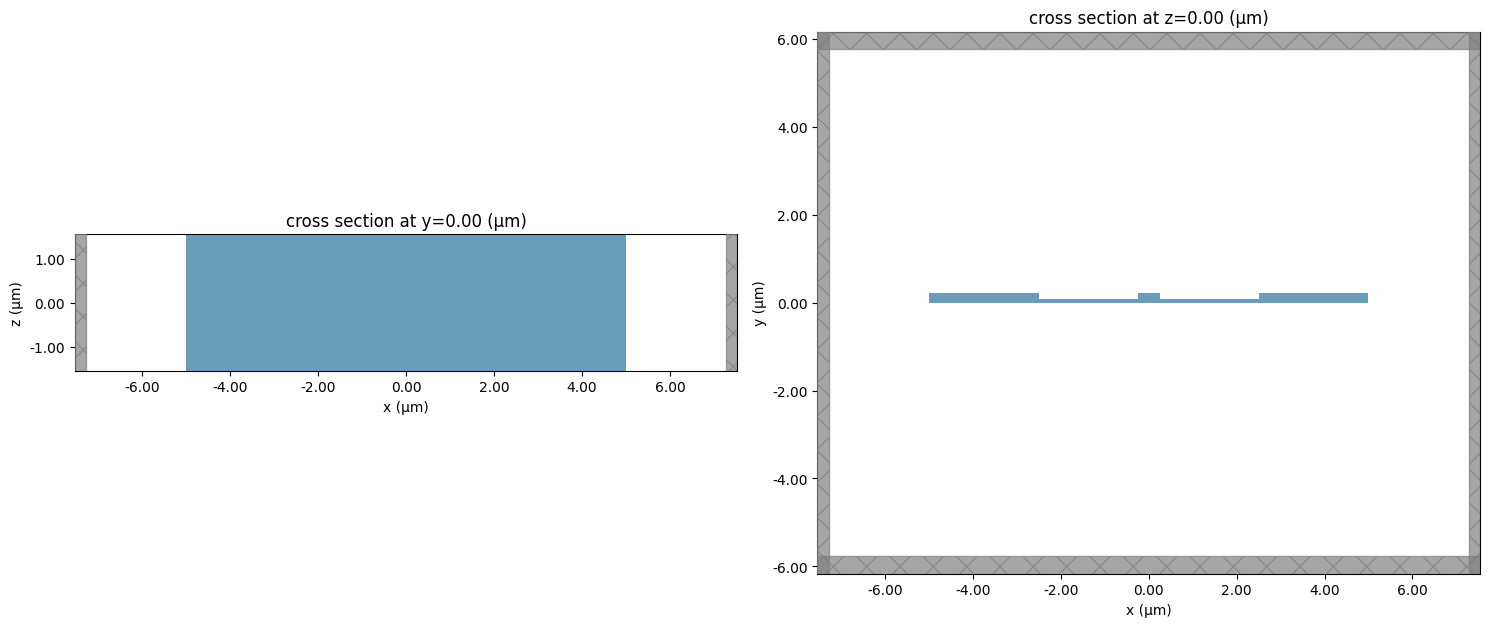

In [25]:
_, ax = plt.subplots(1, 2, figsize=(15, 7))
sim.plot(y=sim.center[1], ax=ax[0])
sim.plot(z=sim.center[2], ax=ax[1])

plt.tight_layout()
plt.show()

In [26]:
def apply_charge(devsim_data):
    perturbed_sims = []
    for n, v in enumerate(devsim_data[charge_global_mnt.name].data_series.parameter_array):
        e_data = devsim_data[charge_global_mnt.name].data_series.get_field("Electrons", n).sel(z=0)
        h_data = devsim_data[charge_global_mnt.name].data_series.get_field("Holes", n).sel(z=0)
        perturbed_sims.append(
            sim.perturbed_mediums_copy(
                electron_density=e_data, 
                hole_density=h_data,
            )
        )
    return perturbed_sims

perturbed_sims = apply_charge(devsim_data)

12:35:31 CEST WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

12:35:33 CEST WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

12:35:36 CEST WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

12:35:38 CEST WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

12:35:40 CEST WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

12:35:43 CEST WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

12:35:45 CEST WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

12:35:47 CEST WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

12:35:50 CEST WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

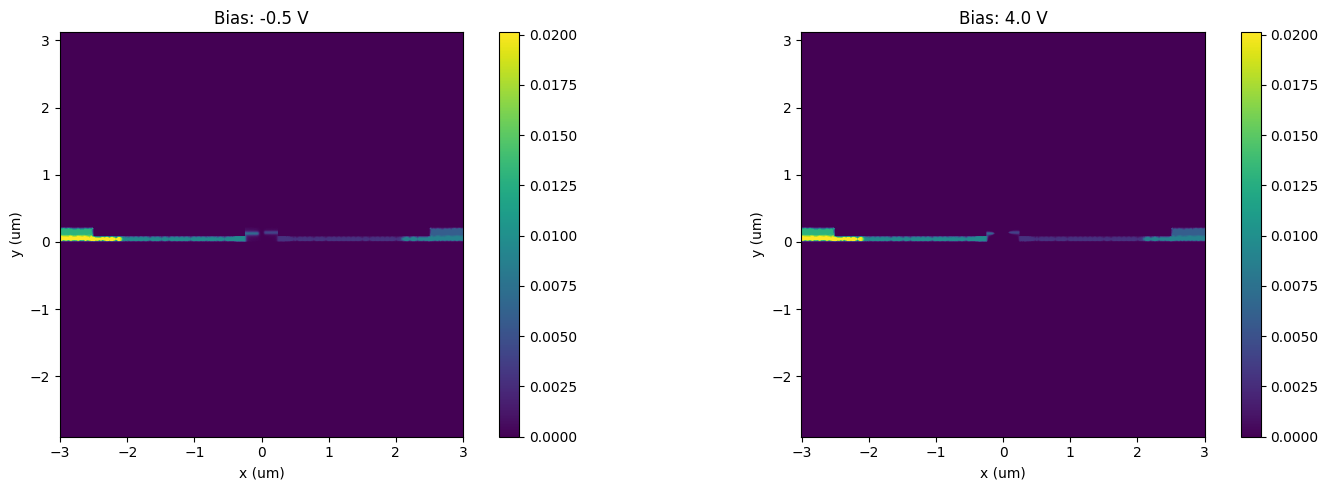

In [27]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))

sampling_region = td.Box(center=(0, h_core/2, 0), size=(6, 6, 0))
eps_undoped = sim.epsilon(box=sampling_region).isel(z=0, drop=True)

for ax_ind, ind in enumerate([0, len(voltages)-1]):
    eps_doped = perturbed_sims[ind].epsilon(box=sampling_region).isel(z=0,  drop=True)
    eps_doped = eps_doped.interp(x=eps_undoped.x, y=eps_undoped.y)
    eps_diff = np.abs(np.real(eps_doped - eps_undoped))
    eps_diff.plot(x="x", ax=ax[ax_ind])
    
    ax[ax_ind].set_aspect("equal")
    ax[ax_ind].set_title(f"Bias: {voltages[ind]:1.1f} V")
    ax[ax_ind].set_xlabel("x (um)")
    ax[ax_ind].set_ylabel("y (um)")

plt.tight_layout()
plt.show()

### Waveguide mode analysis

In [28]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run_batch as run_mode_batch

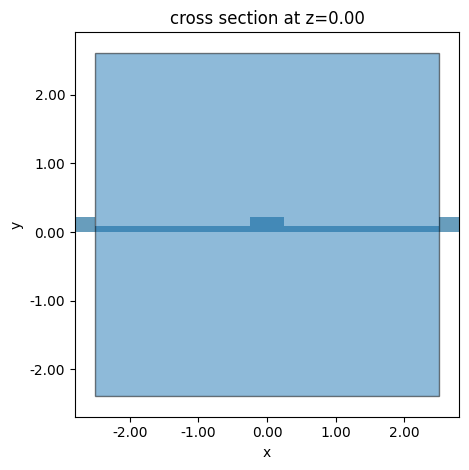

In [29]:
mode_plane = td.Box(center=(0, h_core / 2, 0), size=port_size)

# visualize
ax = sim.plot(z = 0)
mode_plane.plot(z=0, ax=ax, alpha=0.5)
plt.show()

In [30]:
mode_solvers = []
for psim in perturbed_sims:
    ms = ModeSolver(
        simulation=psim,
        plane=mode_plane,
        freqs=np.linspace(freqs[0], freqs[-1], 11),
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
    )
    mode_solvers.append(ms)

In [31]:
#ms_data = run_mode_batch(mode_solvers=mode_solvers, max_workers=1)
ms_data = run_mode_batch(mode_solvers=mode_solvers)

12:35:51 CEST Running a batch of 9 mode solvers.                                
              

Output()

              WARNING: The associated 'Simulation' object contains custom       
              mediums. It will be automatically restricted to the mode solver   
              plane to reduce data for uploading. To force uploading the        
              original 'Simulation' object use 'reduce_simulation=False'.       
              Setting 'reduce_simulation=True' will force simulation reduction  
              in all cases and silence this warning.                            

              WARNING: The associated 'Simulation' object contains custom       
              mediums. It will be automatically restricted to the mode solver   
              plane to reduce data for uploading. To force uploading the        
              original 'Simulation' object use 'reduce_simulation=False'.       
              Setting 'reduce_simulation=True' will force simulation reduction  
              in all cases and silence this warning.                            

              WARNING: The associated 'Simulation' object contains custom       
              mediums. It will be automatically restricted to the mode solver   
              plane to reduce data for uploading. To force uploading the        
              original 'Simulation' object use 'reduce_simulation=False'.       
              Setting 'reduce_simulation=True' will force simulation reduction  
              in all cases and silence this warning.                            

              WARNING: The associated 'Simulation' object contains custom       
              mediums. It will be automatically restricted to the mode solver   
              plane to reduce data for uploading. To force uploading the        
              original 'Simulation' object use 'reduce_simulation=False'.       
              Setting 'reduce_simulation=True' will force simulation reduction  
              in all cases and silence this warning.                            

              WARNING: The associated 'Simulation' object contains custom       
              mediums. It will be automatically restricted to the mode solver   
              plane to reduce data for uploading. To force uploading the        
              original 'Simulation' object use 'reduce_simulation=False'.       
              Setting 'reduce_simulation=True' will force simulation reduction  
              in all cases and silence this warning.                            

              WARNING: The associated 'Simulation' object contains custom       
              mediums. It will be automatically restricted to the mode solver   
              plane to reduce data for uploading. To force uploading the        
              original 'Simulation' object use 'reduce_simulation=False'.       
              Setting 'reduce_simulation=True' will force simulation reduction  
              in all cases and silence this warning.                            

              WARNING: The associated 'Simulation' object contains custom       
              mediums. It will be automatically restricted to the mode solver   
              plane to reduce data for uploading. To force uploading the        
              original 'Simulation' object use 'reduce_simulation=False'.       
              Setting 'reduce_simulation=True' will force simulation reduction  
              in all cases and silence this warning.                            

              WARNING: The associated 'Simulation' object contains custom       
              mediums. It will be automatically restricted to the mode solver   
              plane to reduce data for uploading. To force uploading the        
              original 'Simulation' object use 'reduce_simulation=False'.       
              Setting 'reduce_simulation=True' will force simulation reduction  
              in all cases and silence this warning.                            

              WARNING: The associated 'Simulation' object contains custom       
              mediums. It will be automatically restricted to the mode solver   
              plane to reduce data for uploading. To force uploading the        
              original 'Simulation' object use 'reduce_simulation=False'.       
              Setting 'reduce_simulation=True' will force simulation reduction  
              in all cases and silence this warning.                            

12:42:25 CEST A batch of `ModeSolver` tasks completed successfully!

In [32]:
ms_data[0].to_dataframe()
print(freq0)
print(freqs[3])

193414489032258.06
189662247945032.25


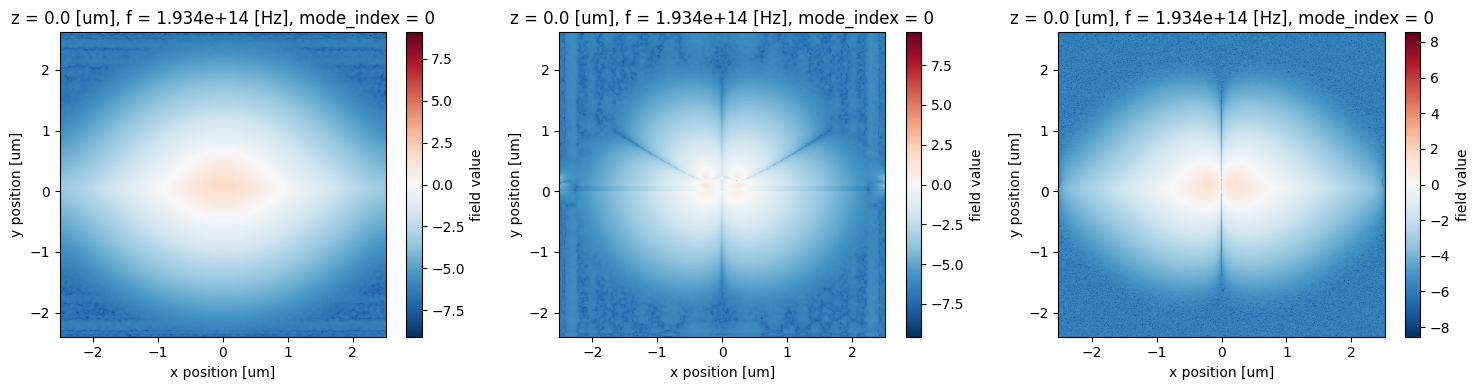

In [33]:
_, ax = plt.subplots(1, 3, figsize=(15, 4))
np.log10(np.abs(ms_data[0].Ex.sel(z=0, f=freq0))).plot(ax=ax[0], x="x")
np.log10(np.abs(ms_data[0].Ey.sel(z=0, f=freq0))).plot(ax=ax[1], x="x")
np.log10(np.abs(ms_data[0].Ez.sel(z=0, f=freq0))).plot(ax=ax[2], x="x")
plt.tight_layout()

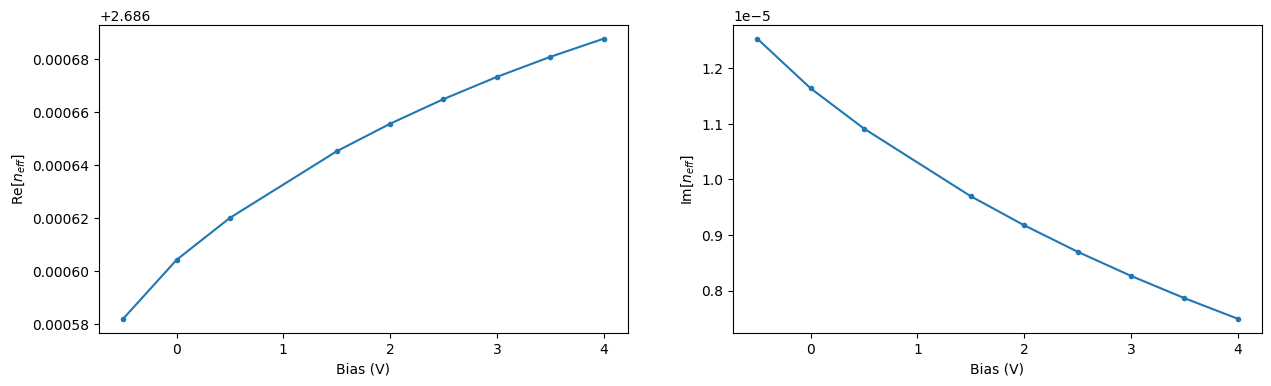

In [34]:
n_eff_freq0 = [md.n_complex.sel(f=freq0, mode_index=0).values for md in ms_data]

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(voltages, np.real(n_eff_freq0), ".-")

ax[0].set_xlabel("Bias (V)")
ax[0].set_ylabel("Re[$n_{eff}$]")

ax[1].plot(voltages, np.imag(n_eff_freq0), ".-")

ax[1].set_xlabel("Bias (V)")
ax[1].set_ylabel("Im[$n_{eff}$]")

plt.show()

### Relative phase change

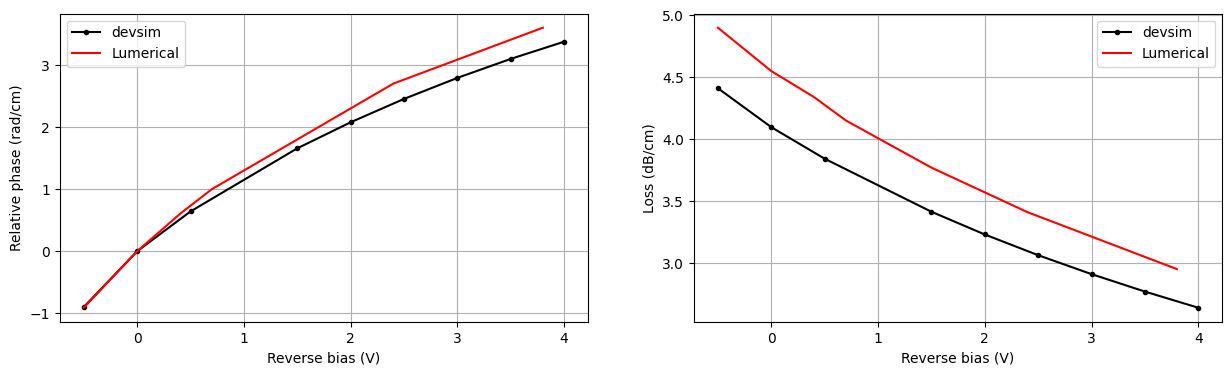

In [36]:
ind_V0 = 1
delta_neff = np.real(n_eff_freq0 - n_eff_freq0[ind_V0])
rel_phase_change = 2*np.pi*delta_neff/wvl_um * 1e4
alpha_dB_cm = 10*4*np.pi*np.imag(n_eff_freq0)/wvl_um*1e4*np.log10(np.exp(1))

# lumerical results
v_lumerical = [-0.5, 0, 0.4, 0.7, 1.5, 2.4, 3.8]
pc_lumerical=[-0.91, 0, 0.6, 1,   1.8, 2.7, 3.6]
loss_lumerical = [4.9, 4.55, 4.34, 4.15, 3.77, 3.41, 2.95]

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(voltages, rel_phase_change, 'k.-', label="devsim")
ax[0].plot(v_lumerical, pc_lumerical, 'r-', label="Lumerical")
ax[0].set_xlabel("Reverse bias (V)")
ax[0].set_ylabel("Relative phase (rad/cm)")
ax[0].grid()
ax[0].legend()

ax[1].plot(voltages, alpha_dB_cm, 'k.-', label="devsim")
ax[1].plot(v_lumerical, loss_lumerical, 'r-', label="Lumerical")
ax[1].set_xlabel("Reverse bias (V)")
ax[1].set_ylabel("Loss (dB/cm)")
ax[1].grid()
ax[1].legend()